In [2]:
from tab_model import TabNetRegressor, TabModel
import torch
import numpy as np
import time
from tqdm import tqdm

/opt/miniconda3/envs/opence-v1.5.1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def getting_datapaths(
    train_idx,
    val_idx,
    files='sunny', 
    target_cols=["ccn_001", "ccn_003", "ccn_006"],
    exclude_cols = ["XLONG", "XLAT"],
):
    # getting colname
    featloc = "/home/kphadke/hackathon/norm_data_timesteps_feat"
    targloc = "/home/kphadke/hackathon/norm_data_timesteps_targ"

    featcols = np.load(f"{featloc}/x_name.npy")
    targcols = np.load(f"{targloc}/y_name.npy")
    
    target_idx = [np.where(targcols == i)[0].item() for i in target_cols ]
    feat_idx   = [np.where(featcols == i)[0].item() for i in featcols if i not in exclude_cols]
    
    # getting paths
    if files == 'sunny':
        # my data
        featloc = "/home/kwoksun2/hackathon_data/norm_data"
        targloc = "/home/kwoksun2/hackathon_data/norm_data"

        train_feat_files = [f"{featloc}/t{t}_feat.npy" for t in train_idx]
        val_feat_files   = [f"{featloc}/t{t}_feat.npy" for t in val_idx  ]

        train_targ_files = [f"{targloc}/t{t}_targ.npy" for t in train_idx]
        val_targ_files   = [f"{targloc}/t{t}_targ.npy" for t in val_idx]
    
    elif files == 'kedar':
        featloc = "/home/kphadke/hackathon/norm_data_timesteps_feat"
        targloc = "/home/kphadke/hackathon/norm_data_timesteps_targ"

        train_feat_files = [f"{featloc}/{t}feat_norm.npy" for t in train_idx]
        val_feat_files   = [f"{featloc}/{t}feat_norm.npy" for t in val_idx  ]

        train_targ_files = [f"{targloc}/{t}targ_norm.npy" for t in train_idx]
        val_targ_files   = [f"{targloc}/{t}targ_norm.npy" for t in val_idx]

    return [np.array(train_feat_files),np.array(train_targ_files)], [np.array(val_feat_files),np.array(val_targ_files)], feat_idx, target_idx

In [448]:
ckpt = torch.load("ep_8_sunny_ccn_001,ccn_003,ccn_006_XLONG,XLAT_tabnet.pt")

# ckpt = torch.load("ep_8_kedar_ccn_001,ccn_003,ccn_006_XLONG,XLAT_tabnet.pt")

# ckpt = torch.load("ep_21_sunny_CHI,CHI_CCN_XLONG,XLAT_tabnet.pt")

In [4]:
ckpt_name = "ep_15_kedar_ccn_001,ccn_003,ccn_006_XLONG,XLAT_tabnet.pt"
ckpt_name = "ep_34_sunny_ccn_001,ccn_003,ccn_006_XLONG,XLAT_tabnet.pt"

In [5]:
import os

folder_name = f'figs_{ckpt_name.replace(".pt","")}'

if not os.path.exists(folder_name):
    os.mkdir(folder_name)
    
ckpt = torch.load(ckpt_name)
model = ckpt['model_state_dict']

In [6]:
ckpt['total_val_loss']

0.01010739924676117

In [7]:
model = ckpt['model_state_dict']
datasource = ckpt['datasource']
exclude_cols =  ckpt['exclude_cols']
target_cols =  ckpt['target_cols']

In [8]:
# getting the idx used in the model
featloc = "/home/kphadke/hackathon/norm_data_timesteps_feat"
targloc = "/home/kphadke/hackathon/norm_data_timesteps_targ"

featcols = np.load(f"{featloc}/x_name.npy")
targcols = np.load(f"{targloc}/y_name.npy")

target_idx = [np.where(targcols == i)[0].item() for i in target_cols ]
feat_idx   = [np.where(featcols == i)[0].item() for i in featcols if i not in exclude_cols]

In [9]:
from sklearn.model_selection import train_test_split

# THIS IS JUST FOR TESTING!!!!!!!
# WILL CHANGE BACK TO 133 later
nsnapshots = 133

# DONT CHANGE THE SEEEDDDDDD!!!!!
np.random.seed(52)
full_indx = np.arange(nsnapshots)
train_idx, val_idx = train_test_split(full_indx, test_size=0.2, train_size=0.8) 

In [10]:
train_files, val_files, feat_idx, target_idx = getting_datapaths(
    train_idx, 
    val_idx, 
    files=datasource, 
    exclude_cols = exclude_cols,
    target_cols  = target_cols
)

# Make ALL SLIDES ALL ATTRS

In [11]:
feat_files, targ_files = val_files
# we are selecting only the first validation data
feat_data = np.load(feat_files[0])
targ_data = np.load(targ_files[0])

if targ_data.ndim == 1:
    targ_data = targ_data.reshape(10,-1).transpose()

In [12]:
def run_plots(val_files):
    feat_files, targ_files = val_files
    
    Nval = len(feat_files)
    
    for i in range(Nval):
        feat_data = np.load(feat_files[i])
        targ_data = np.load(targ_files[i])
        
        tds = torch.utils.data.TensorDataset(
            torch.from_numpy(feat_data[:,feat_idx]).float(), 
            torch.from_numpy(targ_data[:,target_idx]).float()
        )
        dl = torch.utils.data.DataLoader(tds, batch_size=1024, shuffle=False)
        
        # turn it in to a data loader for accessing
        ypred = []
        ytruth = []
        xfeats = []
        with torch.no_grad():
            for feat, targ in dl:
                ypred.append(model(feat.cuda())[0].cpu().numpy())
                ytruth.append(targ.numpy())
                xfeats.append(feat.numpy())

        ypred = np.vstack(ypred)
        ytruth = np.vstack(ytruth)
        xfeats = np.vstack(xfeats)
        
        # convert to 4D arrays
        truth3d =  ytruth.reshape(39,159,169,-1)
        pred3d =  ypred.reshape(39,159,169,-1)
        
        dsname = os.path.basename(feat_files[i]).replace(".npy","")
        # ERROR WITH HEIGHT
        errors = ((truth3d - pred3d)**2).mean(axis=(1,2))
        plt.plot(errors, label=[targcols[i] for i in target_idx ])
        plt.xlabel("Height")
        plt.ylabel("Error")
        plt.legend()
        plt.savefig(f"height_error_{dsname}.png")
        plt.close()
        
        

In [13]:
tds = torch.utils.data.TensorDataset(
    torch.from_numpy(feat_data[:,feat_idx]).float(), 
    torch.from_numpy(targ_data[:,target_idx]).float()
)
dl = torch.utils.data.DataLoader(tds, batch_size=1024, shuffle=False)

In [14]:
# turn it in to a data loader for accessing
ypred = []
ytruth = []
xfeats = []
with torch.no_grad():
    for feat, targ in dl:
        ypred.append(model(feat.cuda())[0].cpu().numpy())
        ytruth.append(targ.numpy())
        xfeats.append(feat.numpy())
        
ypred = np.vstack(ypred)
ytruth = np.vstack(ytruth)
xfeats = np.vstack(xfeats)

In [15]:
truth3d =  ytruth.reshape(39,159,169,-1)
pred3d =  ypred.reshape(39,159,169,-1)

In [16]:
# pct_err = (truth3d - pred3d) / truth3d

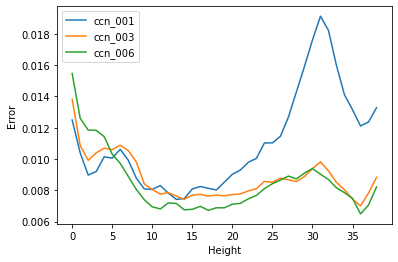

In [17]:
import matplotlib.pyplot as plt

errors = ((truth3d - pred3d)**2).mean(axis=(1,2))
plt.plot(errors, label=[targcols[i] for i in target_idx ])
plt.xlabel("Height")
plt.ylabel("Error")
plt.legend()

In [18]:
# f,ax = plt.subplots(1,2, figsize=(20,10))
# ax.flat[0].imshow(truth3d[0, :,:,2], vmin=-4, vmax=4)
# ax.flat[1].imshow(pred3d[0, :,:,2], vmin=-4, vmax=4)

# ax.flat[0].set_title('truth')
# ax.flat[1].set_title('pred')
# # plt.colorbar()

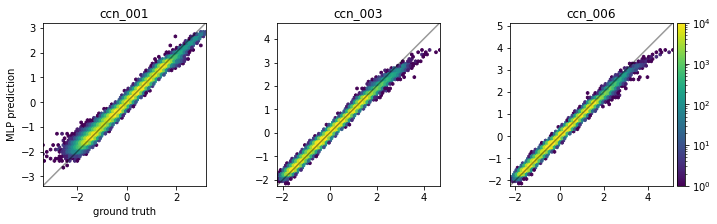

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors


if len(target_idx) == 3:
    nrows=1
    ncols=3
    figsize = (10,3)
    nplots = 3
    labelix = 0
    cbarix = 2
elif len(target_idx) == 2:
    nrows = 1
    ncols = 2
    figsize = (6,3)
    nplots=2
    labelix = 0
    cbarix = 1
elif len(target_idx) == 4:
    nrows = 2
    ncols = 2
    figsize = (6,6)
    nplots=4
    labelix = 2
    cbarix = 1
    

f,axes = plt.subplots(nrows,ncols,figsize=figsize, constrained_layout=True)


for i in range(nplots):
    ax = axes.flat[i]

    _min = ytruth[:,i].min()
    _max = ytruth[:,i].max()
    im = ax.hexbin(ytruth[:,i], ypred[:,i], gridsize=64, extent=(_min,_max,_min,_max), mincnt=1, norm=colors.LogNorm(1,1e4))
#     f.colorbar(im, ax=ax, orientation='horizontal')
    ax.set_aspect(1.0)
    ax.axline([0,0], slope=1, color='k', alpha=0.4)
    ax.set_title(target_cols[i])
    ax.set_xlim(_min,_max)
    ax.set_ylim(_min,_max)

    if i==labelix:
        ax.set_xlabel('ground truth')
        ax.set_ylabel('MLP prediction')

    if i == cbarix:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        f.colorbar(im, cax=cax)

# Attention?

In [20]:
clf = TabNetRegressor(
    input_dim=len(feat_idx), 
    output_dim=len(target_idx), 
    n_d=8, 
    n_a=8
)

clf._set_network()
clf._update_network_params()
clf.network = model

/home/kwoksun2/hackathon_data/tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [23]:
randinx = np.random.randint(0,xfeats.shape[0], 100000)

Text(0.5, 1.0, 'ccn_001, ccn_003, ccn_006')

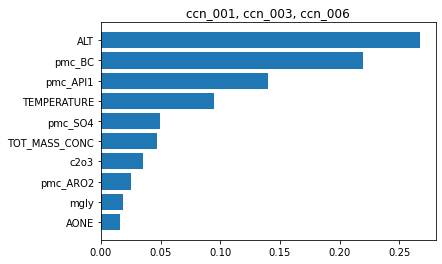

In [24]:
import matplotlib.pyplot as plt

# X, y = next(iter(tdl))

# plt.figure(figsize=(20,10))

clf.feature_importances_ = clf._compute_feature_importances(xfeats[randinx])

ix = np.argsort(clf.feature_importances_)[::-1]
plt.barh( np.array(featcols[feat_idx])[ix[:10]][::-1], clf.feature_importances_[ix[:10]][::-1])
plt.title(', '.join(targcols[target_idx]))

Text(0.5, 1.0, 'ccn_001, ccn_003, ccn_006')

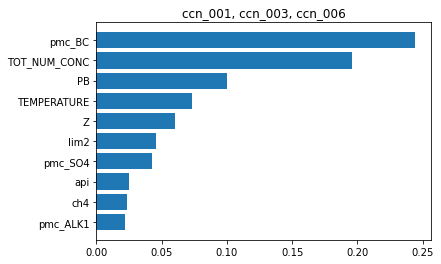

In [25]:
ckpt_name = "ep_17_kedar_ccn_001,ccn_003,ccn_006_XLONG,XLAT_tabnet.pt"
ckpt = torch.load(ckpt_name)
model = ckpt['model_state_dict']
clfkd = TabNetRegressor(
    input_dim=len(feat_idx), 
    output_dim=len(target_idx), 
    n_d=8, 
    n_a=8
)

clfkd._set_network()
clfkd._update_network_params()
clfkd.network = model

clfkd.feature_importances_ = clfkd._compute_feature_importances(xfeats[randinx])

ix = np.argsort(clfkd.feature_importances_)[::-1]
plt.barh( np.array(featcols[feat_idx])[ix[:10]][::-1], clfkd.feature_importances_[ix[:10]][::-1])
plt.title(', '.join(targcols[target_idx]))

Text(0.5, 1.0, 'ccn_001, ccn_003, ccn_006')

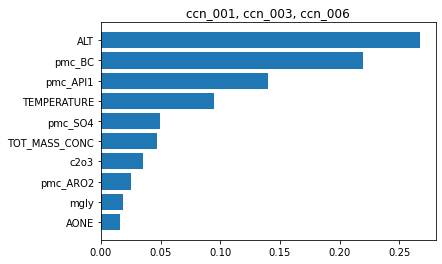

In [26]:
ckpt_name =  "ep_34_sunny_ccn_001,ccn_003,ccn_006_XLONG,XLAT_tabnet.pt"
ckpt = torch.load(ckpt_name)
model = ckpt['model_state_dict']
clfkd = TabNetRegressor(
    input_dim=len(feat_idx), 
    output_dim=len(target_idx), 
    n_d=8, 
    n_a=8
)

clf._set_network()
clfkd._update_network_params()
clfkd.network = model

clfkd.feature_importances_ = clfkd._compute_feature_importances(xfeats[randinx])

ix = np.argsort(clfkd.feature_importances_)[::-1]
plt.barh( np.array(featcols[feat_idx])[ix[:10]][::-1], clfkd.feature_importances_[ix[:10]][::-1])
plt.title(', '.join(targcols[target_idx]))

In [33]:
ckpt_name =  "ep_34_sunny_ccn_001,ccn_003,ccn_006_XLONG,XLAT_tabnet.pt"
ckpt = torch.load(ckpt_name)
model = ckpt['model_state_dict']
clfsun = TabNetRegressor(
    input_dim=len(feat_idx), 
    output_dim=len(target_idx), 
    n_d=8, 
    n_a=8
)

clfsun._set_network()
clfsun._update_network_params()
clfsun.network = model


ckpt_name = "ep_17_kedar_ccn_001,ccn_003,ccn_006_XLONG,XLAT_tabnet.pt"
ckpt = torch.load(ckpt_name)
model = ckpt['model_state_dict']
clfkd = TabNetRegressor(
    input_dim=len(feat_idx), 
    output_dim=len(target_idx), 
    n_d=8, 
    n_a=8
)

clfkd._set_network()
clfkd._update_network_params()
clfkd.network = model

In [32]:
explain_matrix_sum, _ = clfsun.explain(xfeats[randinx])
explain_matrix_kd, _ = clfkd.explain(xfeats[randinx])

KeyboardInterrupt: 

In [31]:
explain_matrix, masks = clfkd.explain(xfeats)

array([[0.        , 0.        , 1.20266092, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.18546307, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.29304504, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.70984262, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.71506995, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.68042374, ..., 0.        , 0.        ,
        0.        ]])

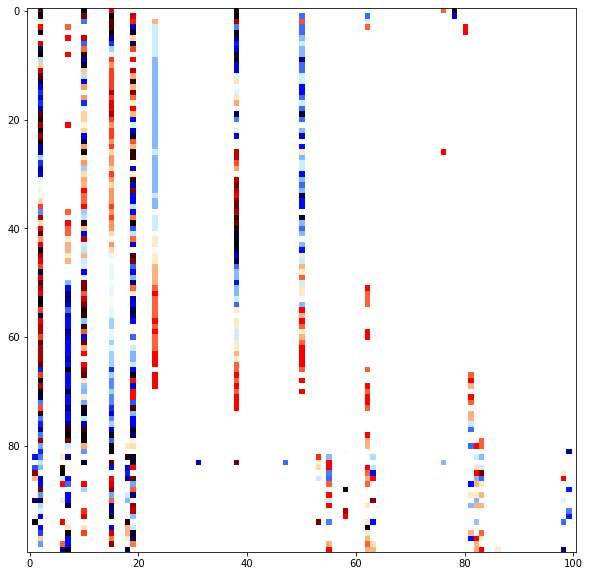

In [47]:
plt.figure(figsize=(20,10))

x = explain_matrix[:100]
x [x ==0] = np.nan

plt.imshow(x,cmap='flag')
# plt.set_aspect(1/100)

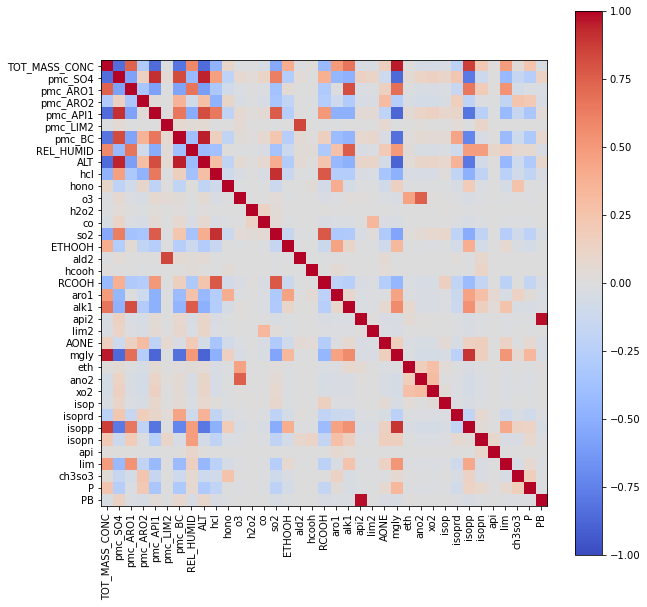

In [46]:
import pandas as pd
# import seaborn as sns
df = pd.DataFrame(explain_matrix, columns=featcols[feat_idx])

nz_mask = df.corr().dropna(how='all').dropna(how='all',axis=1)

f,ax = plt.subplots(figsize=(10,10))
im = ax.imshow(nz_mask, vmin=-1, vmax=1, cmap='coolwarm')
ax.set_xticks(np.arange(len(nz_mask)))
ax.set_yticks(np.arange(len(nz_mask)))
ax.set_xticklabels(nz_mask.columns, rotation=90)
ax.set_yticklabels(nz_mask.columns)
f.colorbar(im)
ax.set_title("Correlation Between the Feature Importance")

In [47]:
idx_important = []
idx_value     = []

for f in np.array_split(xfeats,100):
    t1 = time.time()
    explain_matrix, masks = clf.explain(f)
    norm_mat = explain_matrix/explain_matrix.sum(-1,keepdims=True)
    idx_important.append(norm_mat.argmax(axis=1))
    idx_value.append(norm_mat[np.arange(len(norm_mat)),norm_mat.argmax(axis=1)])
#     print(time.time()-t1)

imp = np.hstack(idx_important)

uqix,uq_counts = np.unique(imp,return_counts=True)

# select 5 most important predictor
n_most_important = min(8, len(uq_counts))
tmp = np.argsort(uq_counts)[::-1][:n_most_important]

top_imp_idx    = uqix[tmp]
top_imp_counts = uq_counts[tmp]

ordered_imp = np.zeros_like(imp)+n_most_important
for i, _idx in enumerate(top_imp_idx):
    ordered_imp[imp == _idx] = i

In [48]:
featcols[feat_idx][top_imp_idx], sum(top_imp_counts)/len(xfeats)

(array(['pmc_BC', 'ALT', 'pmc_API1', 'TEMPERATURE', 'TOT_MASS_CONC',
        'mgly', 'alk1', 'AONE'], dtype='<U13'),
 0.9999217534106448)

In [49]:
ordered_imp = np.zeros_like(imp)+n_most_important
for i, _idx in enumerate(top_imp_idx):
    ordered_imp[imp == _idx] = i

In [50]:
np.unique(ordered_imp, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([398983, 362563, 145988,  89199,  50199,    489,    385,     81,
            82]))

In [51]:
if datasource == "sunny":
    target_std= np.array(
        [1.3428156,
        1.0779657,
        1.0479535,
        0.08097392,
        0.10943509 ,
        0.20763765 ,
        0.2632665 ,
        0.07147439,
        0.091097355,
        1.1029556
        ])
    
    tstd = target_std[target_idx]
    
elif datasource == "kedar":
    target_std = np.load("/home/kphadke/hackathon/targ_std.npy").transpose()
    tstd = target_std[:,target_idx]
    tstd = tstd[:,np.newaxis,np.newaxis,:]

In [52]:
# target_std = np.load("/home/kphadke/hackathon/targ_std.npy").transpose()
# tstd = target_std[:,target_idx]

In [53]:
# plt.plot(target_std[:,0])
# plt.plot(target_std[:,1])
# plt.plot(target_std[:,2])

NameError: name 'fig' is not defined

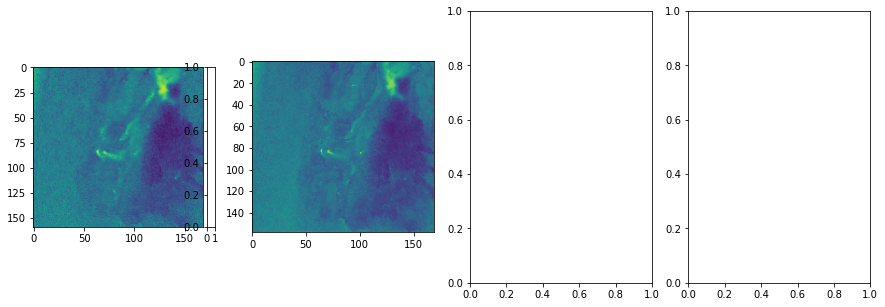

In [54]:
from matplotlib.colors import ListedColormap, LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable


cube_important = ordered_imp.reshape(39,159,169,-1)
pctdiff_cube = np.abs(np.exp((truth3d - pred3d)* tstd) - 1)

zslice = 10

IDX_targ = 0

for IDX_targ in range(len(target_idx)):
    for zslice in range(39):
        f,ax = plt.subplots(1,4, figsize=(15,5))

        td = truth3d[zslice,:,:,0]

        im1 = ax.flat[0].imshow(truth3d[zslice, :,:,IDX_targ], vmin=td.min(), vmax=td.max())
        im2 = ax.flat[1].imshow(pred3d[zslice, :,:,IDX_targ], vmin=td.min(), vmax=td.max())

        divider = make_axes_locatable(ax.flat[0])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(im1, cax=cax, orientation='vertical')

        divider = make_axes_locatable(ax.flat[1])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(im1, cax=cax, orientation='vertical')
        
        im3 = ax.flat[2].imshow(pctdiff_cube[zslice, :,:,IDX_targ], vmin=1e-2,vmax=1e0,cmap='magma', norm= LogNorm(1e-2,1))
        divider = make_axes_locatable(ax.flat[2])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(im3, cax=cax, orientation='vertical')
        

        lcmap = cm.get_cmap('Pastel1')
        cMap = ListedColormap([lcmap(i) for i in range(n_most_important+1)])

        heatmap = ax.flat[3].imshow(cube_important[zslice, :,:,0]+0.5, cmap=cMap, vmin=0, vmax=n_most_important+1)

        divider = make_axes_locatable(ax.flat[3])
        cax = divider.append_axes("right", size="5%", pad=0.05)

        cbar = fig.colorbar(heatmap, cax=cax, orientation='vertical')
        cbar.set_ticks(np.arange(n_most_important+1)+0.5)
        cbar.ax.set_yticklabels(list(featcols[feat_idx][top_imp_idx]) + ["Rest"])
        # cbar.set_label('# of contacts', rotation=270)

        ax.flat[2].set_title("percentage error")
        ax.flat[3].set_title(f"zslice = {zslice}; { targcols[target_idx][IDX_targ] }")

        ax.flat[0].set_title('truth')
        ax.flat[1].set_title('pred')
        ax.flat[0].set_xticks([])
        ax.flat[0].set_yticks([])

        ax.flat[1].set_xticks([])
        ax.flat[1].set_yticks([])
        ax.flat[2].set_xticks([])
        ax.flat[2].set_yticks([])
        
        ax.flat[3].set_xticks([])
        ax.flat[3].set_yticks([])
        # plt.colorbar()
        
        
        plt.show()
        plt.close(f)
# plt.close('all')

$$z_0 = (log(y_0) - \mu)/ \sigma $$
$$z_1 = (log(y_1) - \mu)/ \sigma $$

$$y_0/y_1 - | 1 = e^{\sigma (z_1 - z_0)} - 1 |$$


In [372]:
target_std= np.array(
    [1.3428156,
    1.0779657,
    1.0479535,
    0.08097392,
    0.10943509 ,
    0.20763765 ,
    0.2632665 ,
    0.07147439,
    0.091097355,
    1.1029556
    ])

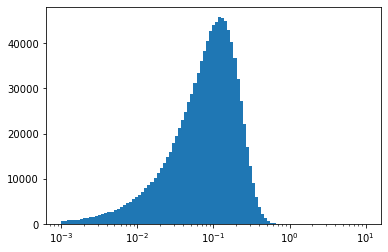

In [575]:
plt.hist(pctdiff_cube[...,0].flatten(),bins=np.logspace(-3,1,100))
plt.xscale('log')

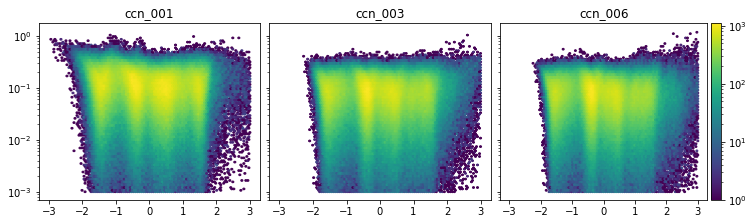

In [576]:
from matplotlib.colors import ListedColormap, LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

if len(target_idx) == 3:
    nrows=1
    ncols=3
    figsize = (10,3)
    nplots = 3
    labelix = 0
    cbarix = 2
elif len(target_idx) == 2:
    nrows = 1
    ncols = 2
    figsize = (6,3)
    nplots=2
    labelix = 0
    cbarix = 1
elif len(target_idx) == 4:
    nrows = 2
    ncols = 2
    figsize = (6,6)
    nplots=4
    labelix = 2
    cbarix = 1


f,ax = plt.subplots(nrows,ncols, figsize=figsize,constrained_layout=True,sharex=True,sharey=True)
for IDX_targ in range(len(target_idx)):
    im = ax.flat[IDX_targ].hexbin(truth3d[...,IDX_targ].flatten(), 
                             pctdiff_cube[...,IDX_targ].flatten()+1e-16,yscale='log', 
                             mincnt=1, extent=(-3,3,-3,0.1), bins='log')
    ax.flat[IDX_targ].set_title(f"{targcols[target_idx][IDX_targ]}")
    
divider = make_axes_locatable(ax.flat[IDX_targ])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = f.colorbar(im, cax=cax, orientation='vertical')
plt.show()
plt.close(f)

In [577]:
targcols

array(['ccn_001', 'ccn_003', 'ccn_006', 'CHI', 'CHI_CCN', 'D_ALPHA',
       'D_GAMMA', 'D_ALPHA_CCN', 'D_GAMMA_CCN', 'PM25'], dtype='<U11')

Text(0, 0.5, 'Fraction with error less than')

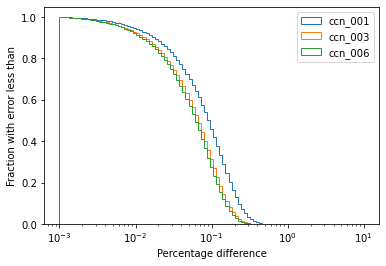

In [578]:
for IDX_targ in range(len(target_idx)):
    plt.hist( pctdiff_cube[...,IDX_targ].flatten()+1e-16, 
             bins = np.logspace(-3,1,100), cumulative=-1, 
             density=True, histtype='step', 
             label=f"{targcols[target_idx][IDX_targ]}")

plt.legend()
plt.xscale('log')
plt.xlabel("Percentage difference")
plt.ylabel("Fraction with error less than")

Text(0, 0.5, 'Fraction with error less than')

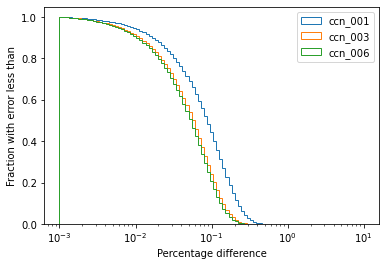

In [530]:
for IDX_targ in range(len(target_idx)):
    plt.hist( pctdiff_cube[...,IDX_targ].flatten()+1e-16, 
             bins = np.logspace(-3,1,100), cumulative=-1, 
             density=True, histtype='step', 
             label=f"{targcols[target_idx][IDX_targ]}")

plt.legend()
plt.xscale('log')
plt.xlabel("Percentage difference")
plt.ylabel("Fraction with error less than")

<ErrorbarContainer object of 3 artists>

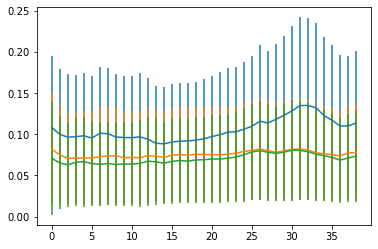

In [579]:
plt.errorbar(np.arange(39), pctdiff_cube[...,0].mean(axis=(1,2)), yerr=pctdiff_cube[...,0].std(axis=(1,2)))
plt.errorbar(np.arange(39), pctdiff_cube[...,1].mean(axis=(1,2)), yerr=pctdiff_cube[...,1].std(axis=(1,2)))
plt.errorbar(np.arange(39), pctdiff_cube[...,2].mean(axis=(1,2)), yerr=pctdiff_cube[...,2].std(axis=(1,2)))

In [ ]:
pctdiff_cube[...,0].mean(axis=(1,2))